### Tasks to Complete

1. Review the descriptive statistics of the sample:

   - Characteristics such as year of training, age, gender, race, and prior education.
   - Mean scores of PPOS and PPOS subscales.

2. Perform comparisons of PPOS and subscales:

   - By year of training.
   - By gender (Male/Female).
   - By prior education (e.g., CEGEP, Bachelors, Graduate).
   - By intended specialization:
     - Primary vs. non-primary care.
     - Surgical vs. non-surgical.

3. Clean and preprocess the dataset:

   - Ensure all columns are renamed appropriately using the `column_rename` dictionary.
   - Drop unnecessary columns (`gender_other`, `race_other`).

4. Explore and visualize the data:

   - Generate plots to visualize the distribution of key variables (e.g., age, PPOS scores).
   - Create comparison plots for PPOS and subscales based on the specified categories.

5. Document findings and insights:
   - Summarize the key characteristics of the sample.
   - Highlight significant differences in PPOS and subscales across the specified categories.


In [57]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re
from unidecode import unidecode

# plt.style.use('dark_background')
sns.set_theme(style="darkgrid", palette="bright")

In [ ]:
column_rename = {
    "Record ID": "record_id",
    "Timepoint": "timepoint",
    "PPOS": "ppos",
    "PPOS-S": "ppos_s",
    "PPOS-C": "ppos_c",
    "Age:": "age",
    "Gender Identity": "gender",
    "Other: Specify": "gender_other",
    "How proficient are you in French?": "french_proficiency",
    "How proficient are you in English?": "english_proficiency",
    "Do you speak any other languages? Please specify your proficiency (Fluent, Moderate, Basic). Please answer in format: [Language, Proficiency] for all languages.    ": "other_languages",
    "Please specify if other level of training": "other_training",
    "Please list all previous education you have completed (e.g., CEGEP, BSc, MSc, PHD, other professional certification). Please answer in format [degree, year of completion]": "prior_education",
    "Site of study": "site_of_study",
    "Do you have an intended specialization (including Family Medicine)?": "intended_specialization",
    "What is your intended specialization?": "specialty",
    "Other (Please specify):": "race_other",
    # Cultural identity columns
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=Black/African Canadian)": "cultural_black",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=East Asian (e.g., Chinese, Japanese, Korean))": "cultural_east_asian",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=Indigenous (First Nations, Métis, Inuit))": "cultural_indigenous",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=Middle Eastern/North African (e.g., Arab, Persian))": "cultural_middle_eastern",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=Latin American (e.g., Mexican, Brazilian, Coloumbian))": "cultural_latin_american",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=South Asian (e.g., Indian, Bangladeshi, Sri Lankan))": "cultural_south_asian",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=South East Asian (e.g. Filipino, Vietnamese, Thai))": "cultural_southeast_asian",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=White/Caucasian)": "cultural_white",
    "Which Cultural Identities do you identify as? (Select that apply)   (choice=Other (please specify))": "cultural_other",
}

df = pd.read_excel("MSHumanism_CleanQuantData_250625_AC.xlsx", sheet_name="Full Data")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")].rename(columns=column_rename)
df['prior_education'] = df["prior_education"].apply(unidecode)
df.head()

,record_id,timepoint,ppos,ppos_s,ppos_c,age,gender,gender_other,cultural_black,cultural_east_asian,...,cultural_other,race_other,french_proficiency,english_proficiency,other_languages,other_training,prior_education,site_of_study,intended_specialization,specialty
0,1,M2 (TCP),88,40,48,21,Female,NaN,Unchecked,Unchecked,...,Unchecked,NaN,Fluent,Fluent,"Spanish (moderate), Arab (moderate)",NaN,"CEGEP, 2022",Montreal,Yes,Internal medicine
1,2,M4,75,29,46,42,Female,NaN,Unchecked,Unchecked,...,Unchecked,NaN,Fluent,Fluent,"Hindi, Punjabi, Urdu",NaN,Graduate studies in Experimental Medicine,Montreal,No,NaN
2,3,M3,76,38,38,30,Male,NaN,Unchecked,Unchecked,...,Unchecked,NaN,Moderate,Fluent,"Arabic, proficient",NaN,"Bsc, jd, llm",Montreal,Yes,Dermatology
3,5,M2 (TCP),76,42,34,25,Male,NaN,Unchecked,Unchecked,...,Unchecked,NaN,Moderate,Fluent,none,NaN,"CEGEP, Bsc, Msc",Montreal,Yes,internal medicine - maybe medical oncology
4,7,M3,61,33,28,27,Male,NaN,Checked,Unchecked,...,Unchecked,NaN,Fluent,Fluent,Basic Japanese,NaN,BSc Human Kinetics 2020 BSc Translational and...,Montreal,Yes,Anesthesia


In [59]:
# dropping columns with 0 or non-essential data
df = df.drop(columns=["gender_other", "race_other", "record_id"])

Cannot make race into one column since some people have 2+ selected


In [60]:
def checked(row):
    return row.lower() == "checked"


checked_cols = [
    "cultural_black",
    "cultural_east_asian",
    "cultural_indigenous",
    "cultural_middle_eastern",
    "cultural_latin_american",
    "cultural_south_asian",
    "cultural_southeast_asian",
    "cultural_white",
    "cultural_other",
]
if df[checked_cols[0]].dtype != "bool":
    df[checked_cols] = df[checked_cols].map(checked)

In [ ]:
# make degree columns

df['has_dec'] = df['prior_education'].str.lower().str.replace(".","").str.contains('dec|cegep|bac|cegep')
df['has_bsc'] = df['prior_education'].str.lower().str.replace(".","").str.contains('bsc|undergrad|b.asc|b.sc|bs|ba|bachelor|bkin|beng|b')
df['has_msc'] = df['prior_education'].str.lower().str.replace(".","").str.contains('msc|graduate|ma')
df['has_doc'] = df['prior_education'].str.lower().str.replace(".","").str.contains('phd|pharmd|pharm.d')


#df[['prior_education', 'has_dec', 'has_bsc', 'has_msc', 'has_doc']].sort_values(by="has_doc")
# Filter rows where any of the 'has_' columns are False and print them
#edu_cols = [col for col in df.columns if col.startswith('has_')]
# df.loc[~df[has_columns].any(axis=1), ['prior_education'] + has_columns]

Part 1: Review the descriptive statistics:

- Year of training
- Age
- Gender
- Race
- Prior education
- Mean scores of PPOS and subscales


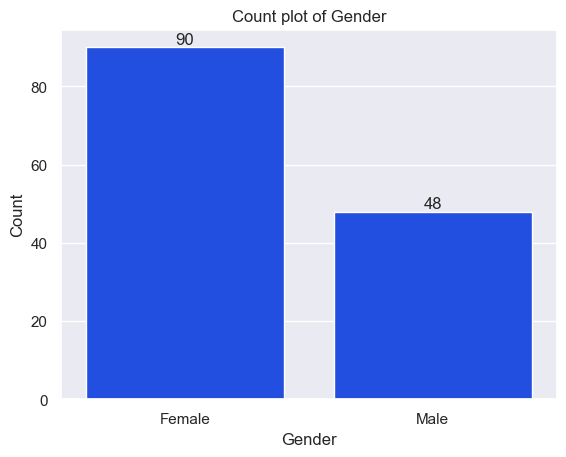

In [63]:
ax = sns.countplot(df, x="gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Count plot of Gender")
for p in ax.patches:
    ax.annotate(
        int(p.get_height()),
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=12,
    )
plt.show()

count    138.000000
mean      25.637681
std        4.197570
min       18.000000
25%       23.000000
50%       25.000000
75%       27.750000
max       43.000000
Name: age, dtype: float64


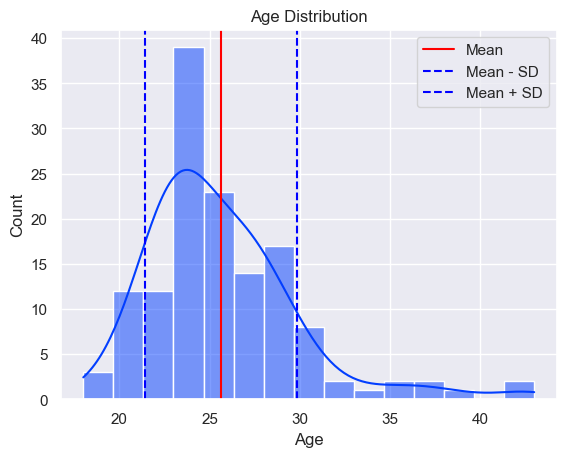

In [ ]:
drop_desc = ["25%", "50%", "75%"]
df["age"].describe().drop(drop_desc)

print(df['age'].describe())

age_mean = df['age'].mean()
age_std = df['age'].std()
sns.histplot(df['age'], bins=15, kde=True)
plt.title('Age Distribution')
plt.axvline(age_mean, c='red')
plt.axvline(age_mean - age_std, c = "blue" , linestyle="--")
plt.axvline(age_mean + age_std, c = "blue" , linestyle="--")
plt.xlabel('Age')
plt.show()

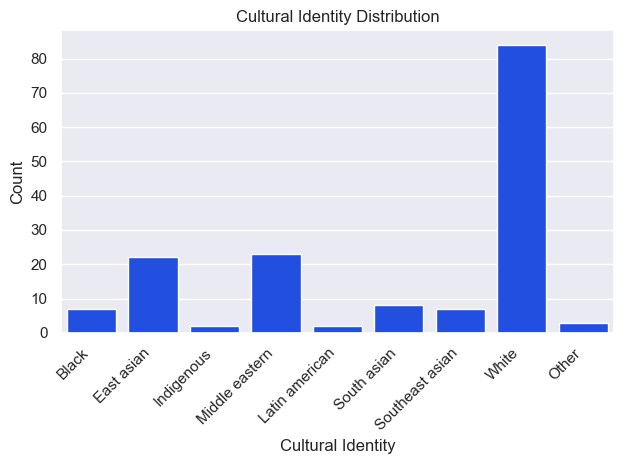

,Cultural Identity,Count
0,Black,7
1,East asian,22
2,Indigenous,2
3,Middle eastern,23
4,Latin american,2
5,South asian,8
6,Southeast asian,7
7,White,84
8,Other,3


In [95]:
race_cols = [col for col in df.columns if col.startswith('cultural_')]

cultural_counts = df[race_cols].sum().reset_index()
cultural_counts.columns = ['Cultural Identity', 'Count']

cultural_counts['Cultural Identity'] = cultural_counts['Cultural Identity'].str.replace("cultural_","").str.replace('_', " ").str.capitalize()
sns.barplot(data=cultural_counts, x='Cultural Identity', y='Count')
plt.title('Cultural Identity Distribution')
plt.ylabel('Count')
plt.xlabel('Cultural Identity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

cultural_counts

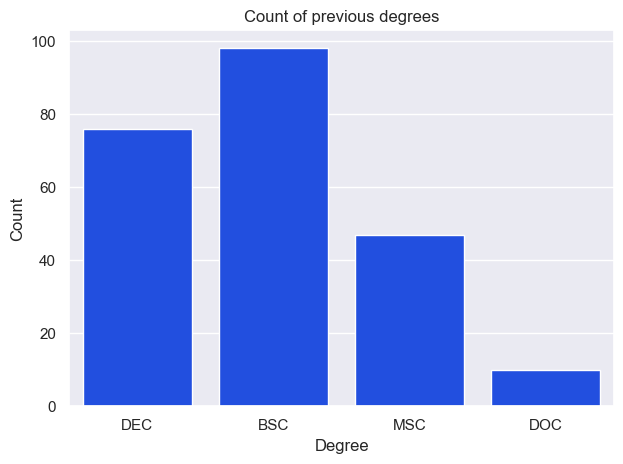

In [ ]:
edu_cols = [col for col in df.columns if col.startswith('has_')]
edu_counts = df[edu_cols].sum().reset_index()
edu_counts.columns = ['Education', 'Count']
edu_counts['Education'] = edu_counts["Education"].str.upper().str.split("_").str[1]

edu_counts

sns.barplot(edu_counts, x='Education', y='Count')
plt.title("Count of previous degrees")
plt.xlabel("Degree")
plt.tight_layout()
plt.show()


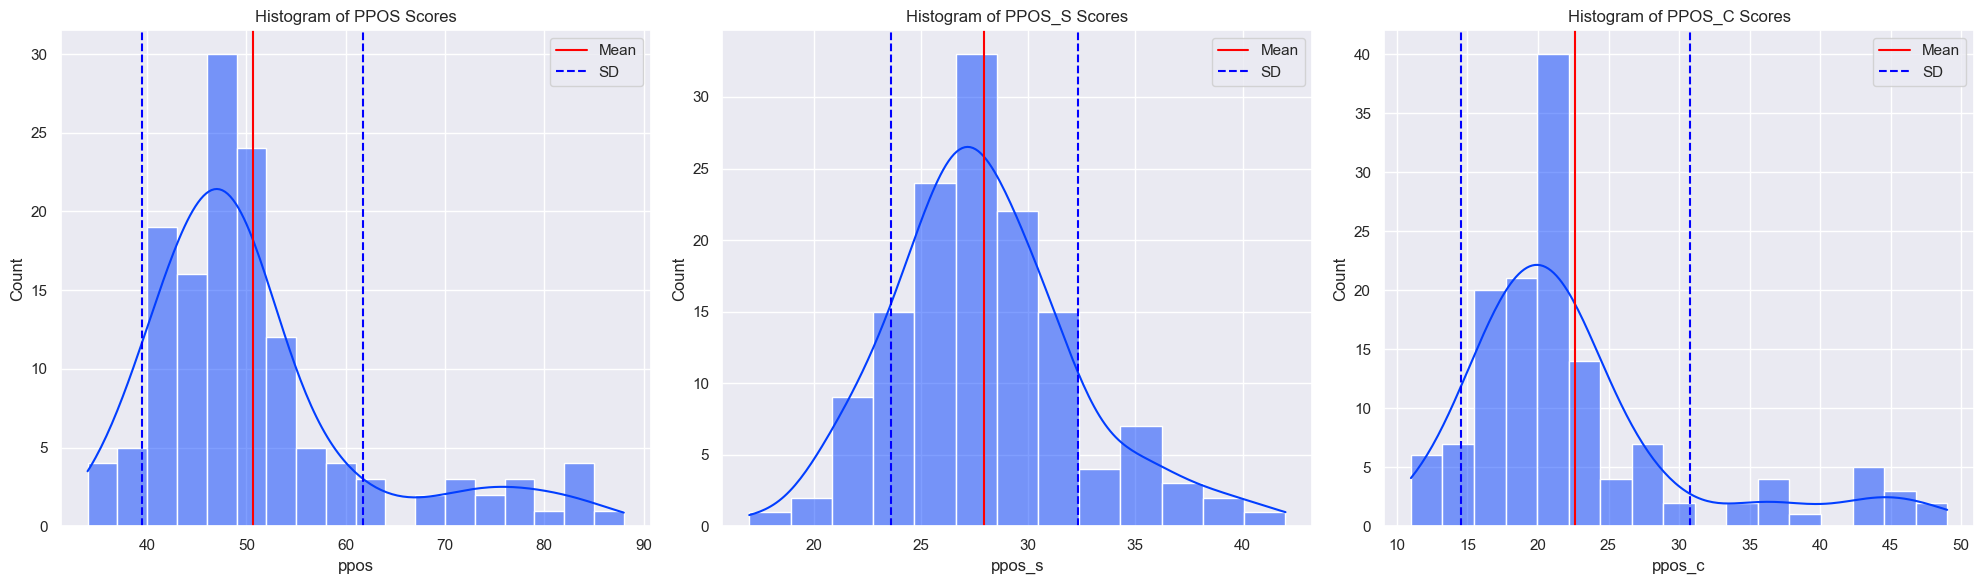

In [66]:
# df['gender'].value_counts()
# df[['ppos', 'ppos_s', 'ppos_c']].describe().loc[['mean', 'std']]

score_cols = ["ppos", "ppos_s", "ppos_c"]
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, col in zip(axes, score_cols):
    sns.histplot(df, x=col, ax=ax, kde=True)
    mean = df[col].mean()
    std = df[col].std()
    ax.axvline(mean, color="red", label="Mean")
    ax.axvline(
        mean + std,
        color="blue",
        linestyle="--",
    )
    ax.axvline(mean - std, color="blue", linestyle="--", label="SD")
    ax.set_title(f"Histogram of {col.upper()} Scores")
    ax.legend()

plt.tight_layout()
plt.show()

In [67]:
def clean_timepoint(s):
    s = s.upper().strip()
    matches = re.match(r"M\d+", s)
    return matches.group() if matches is not None else None


df["timepoint"] = df["timepoint"].map(clean_timepoint)

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   timepoint                 138 non-null    object
 1   ppos                      138 non-null    int64 
 2   ppos_s                    138 non-null    int64 
 3   ppos_c                    138 non-null    int64 
 4   age                       138 non-null    int64 
 5   gender                    138 non-null    object
 6   cultural_black            138 non-null    bool  
 7   cultural_east_asian       138 non-null    bool  
 8   cultural_indigenous       138 non-null    bool  
 9   cultural_middle_eastern   138 non-null    bool  
 10  cultural_latin_american   138 non-null    bool  
 11  cultural_south_asian      138 non-null    bool  
 12  cultural_southeast_asian  138 non-null    bool  
 13  cultural_white            138 non-null    bool  
 14  cultural_other            